https://github.com/walsvid/CoordConv/blob/master/CoordConv.ipynb

This notebook does something opposite from the original notebook.

In [1]:
from dlcliche.notebook import *
from dlcliche.utils import *

import torch
import torch.nn as nn
import torch.nn.modules.conv as conv
import torch.utils.data as utils
import torch.nn.functional as F

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [2]:
#!wget https://raw.githubusercontent.com/walsvid/CoordConv/master/coordconv.py

from coord_conv import CoordConv

datatype = 'uniform'
assert datatype in ['uniform', 'quadrant']

if not os.path.exists('data-uniform/'):
    os.makedirs('data-uniform/')

if not os.path.exists('data-quadrant/'):
    os.makedirs('data-quadrant/')

np.random.seed(0)
torch.manual_seed(0)

(3136, 1, 64, 64)


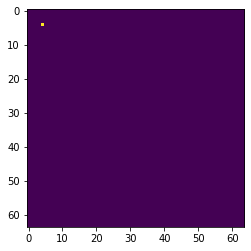

In [3]:
onehots = np.pad(np.eye(3136, dtype='float32').reshape((3136, 56, 56, 1)),
                     ((0, 0), (4, 4), (4, 4), (0, 0)), mode="constant")
onehots = onehots.transpose(0, 3, 1, 2)

onehots_tensor = torch.from_numpy(onehots)

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(9,9), padding=4, stride=1)
w = torch.ones(1, 1, 9, 9)
conv_layer.weight.data = w

images_tensor = conv_layer(onehots_tensor)
images = images_tensor.detach().numpy()

print(onehots.shape)
plt.imshow(onehots[0].reshape(64,64));

(3136, 1, 64, 64)


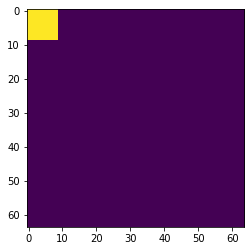

In [4]:
print(images.shape)
plt.imshow(images[0].reshape(64,64));

In [5]:
# Create the uniform datasets
indices = np.arange(0, len(onehots), dtype='int32')
train, test = train_test_split(indices, test_size=0.2, random_state=0)

train_onehot = onehots[train]
train_images = images[train]

test_onehot = onehots[test]
test_images = images[test]

np.save('data-uniform/train_onehot.npy', train_onehot)
np.save('data-uniform/train_images.npy', train_images)
np.save('data-uniform/test_onehot.npy', test_onehot)
np.save('data-uniform/test_images.npy', test_images)


Train target :  (2508, 2) 0.9365079365079365 0.06349206349206349
Test target :  (628, 2) 0.9365079365079365 0.06349206349206349


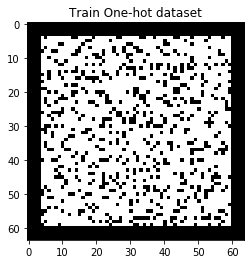

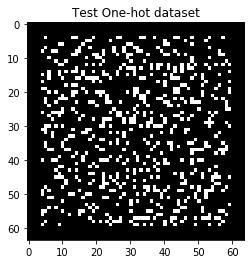

In [20]:
# Load the one hot datasets
train_onehot = np.load('data-uniform/train_onehot.npy').astype('float32')
test_onehot = np.load('data-uniform/test_onehot.npy').astype('float32')

def get_target(onehot):
    pos = np.where(onehot == 1.0)
    coordX = pos[2]
    coordY = pos[3]
    # Normalize the datasets
    return np.array(list(zip(coordX, coordY))) / (64. - 1.)  # 64x64 grid, 0-based index

# (N, C, H, W)
# make the train and test datasets
# train
train_target = get_target(train_onehot)

# test
test_target = get_target(test_onehot)


print('Train target : ', train_target.shape, train_target.max(), train_target.min())
print('Test target : ', test_target.shape, test_target.max(), test_target.min())

# Visualize the datasets
plt.imshow(np.sum(train_onehot, axis=0)[0, :, :], cmap='gray')
plt.title('Train One-hot dataset')
plt.show()
plt.imshow(np.sum(test_onehot, axis=0)[0, :, :], cmap='gray')
plt.title('Test One-hot dataset')
plt.show()

In [84]:
# settings
text_device = 'cuda'
device = torch.device(text_device)
coord_conv = True
epochs = 10

In [85]:
# model definition

class Net(nn.Module):
    def __init__(self, coord_conv=True):
        super(Net, self).__init__()
        if coord_conv:
            self.convX = CoordConv(1, 32, 3, with_r=True)
        else:
            self.convX = nn.Conv2d(1, 32, 3)
        self.poolX = nn.MaxPool2d(3, stride=2)
        self.conv1 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.linear = nn.Linear(3200, 2)

    def forward(self, x):
        x = self.convX(x)
        x = self.poolX(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

net = Net(coord_conv=coord_conv).to(device)

summary(net, input_size=(1, 64, 64), device=text_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]           1,184
         CoordConv-2           [-1, 32, 62, 62]               0
         MaxPool2d-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
         MaxPool2d-5           [-1, 64, 13, 13]               0
            Conv2d-6          [-1, 128, 11, 11]          73,856
         MaxPool2d-7            [-1, 128, 5, 5]               0
            Linear-8                    [-1, 2]           6,402
Total params: 99,938
Trainable params: 99,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.70
Params size (MB): 0.38
Estimated Total Size (MB): 3.10
----------------------------------------------------------------


In [86]:
train_tensor_x = torch.stack([torch.Tensor(i) for i in train_onehot]).to(device)
train_tensor_y = torch.stack([torch.Tensor(i) for i in train_target]).to(device)

train_dataset = utils.TensorDataset(train_tensor_x,train_tensor_y)
train_dataloader = utils.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_tensor_x = torch.stack([torch.Tensor(i) for i in test_onehot]).to(device)
test_tensor_y = torch.stack([torch.Tensor(i) for i in test_target]).to(device)

test_dataset = utils.TensorDataset(test_tensor_x,test_tensor_y)
test_dataloader = utils.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [87]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def sigmoid_mse(input, target):
    input = input.sigmoid()
    return nn.MSELoss()(input, target)
criterion = sigmoid_mse


def train(epoch, net, train_dataloader, optimizer, criterion, device):
    net.train()
    iters = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        iters += len(data)
        print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, iters, len(train_dataloader.dataset),
                100. * (batch_idx + 1) / len(train_dataloader), loss.data.item()), end='\r', flush=True)
    print("")
    

epochs = 10

for epoch in range(1, epochs + 1):
    train(epoch, net, train_dataloader, optimizer, criterion, device)

Train Epoch: 1 [2508/2508 (100%)] Loss: 0.010901
Train Epoch: 2 [2508/2508 (100%)] Loss: 0.000824
Train Epoch: 3 [2508/2508 (100%)] Loss: 0.000326
Train Epoch: 4 [2508/2508 (100%)] Loss: 0.000145
Train Epoch: 5 [2508/2508 (100%)] Loss: 0.000077
Train Epoch: 6 [2508/2508 (100%)] Loss: 0.000048
Train Epoch: 7 [2508/2508 (100%)] Loss: 0.000035
Train Epoch: 8 [2508/2508 (100%)] Loss: 0.000032
Train Epoch: 9 [2508/2508 (100%)] Loss: 0.000026
Train Epoch: 10 [2508/2508 (100%)] Loss: 0.000037



Test set: Average loss: 0.0001



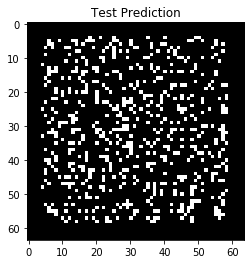

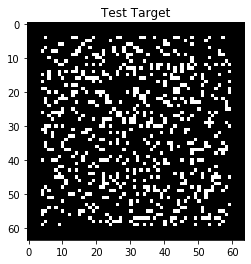

In [88]:
test(net, test_dataloader, optimizer, criterion, device)


Test set: Average loss: 0.0002



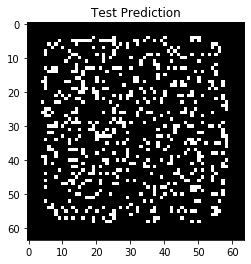

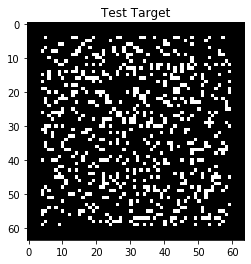

In [83]:
def test(net, test_loader, optimizer, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    pred_logits = torch.tensor([])
    projection = np.zeros((64, 64), dtype=np.float32)
    for data, target in test_loader:
        with torch.no_grad():
            data, target = data.to(device), target.to(device)
            output = net(data)
            logits = output.sigmoid()
            #print(logits)
            pred_logits = torch.cat((pred_logits, logits.cpu()), dim=0)
            test_loss += criterion(output, target).item()
            # plot
            xy = (logits * (64 - 1.)).detach().cpu().numpy().astype(np.uint8)
            for x, y in xy:
                projection[y, x] = 1.

    test_loss /= len(test_loader) # loss function already averages over batch size
    print(f'\nTest set: Average loss: {test_loss:.4f}\n')
    
    plt.imshow(projection, cmap='gray')
    plt.title('Test Prediction')
    plt.show()
    plt.imshow(np.sum(test_onehot, axis=0)[0, :, :], cmap='gray')
    plt.title('Test Target')
    plt.show()
    
test(net, test_dataloader, optimizer, criterion, device)